# 双極子データの解析：特に260cm-1の水素結合のピークに関して

## 2023/12/6 :: ohtakaで解析した双極子データ（50ps_1から50ps_5）をロードして誘電関数まで．


## 2024/1/21 :: とりあえずH-O間の距離のスペクトルを調べてみて，今後の足がかりとしておく．




https://qiita.com/mimitaro/items/9fa7e054d60290d13bfc
https://qiita.com/Broccolingual/items/9838443aa6838a867041
https://qiita.com/knknkn1162/items/87b1153c212b27bd52b4
https://docs.python-guide.org/writing/logging/#example-configuration-directly-in-code

In [1]:
from logging import getLogger, StreamHandler, Formatter, DEBUG, INFO, WARNING, CRITICAL
# create logger
logger = getLogger('simple_example')
logger.setLevel(DEBUG)

# create console handler and set level to debug
ch = StreamHandler()
ch.setLevel(DEBUG)

# create formatter
formatter = Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# add formatter to ch
ch.setFormatter(formatter)

# add ch to logger
logger.addHandler(ch)

# from logging import getLogger, Formatter, StreamHandler, FileHandler, DEBUG, INFO

# def get_module_logger(module, verbose):
#     logger = getLogger(module)
#     logger = _set_handler(logger, StreamHandler(), False)
#     logger = _set_handler(logger, FileHandler(LOG_DIR), verbose)
#     logger.setLevel(DEBUG)
#     logger.propagate = False
#     return logger


# def _set_handler(logger, handler, verbose):
#     if verbose:
#         handler.setLevel(DEBUG)
#     else:
#         handler.setLevel(INFO)
#     handler.setFormatter(Formatter('%(asctime)s %(name)s:%(lineno)s %(funcName)s [%(levelname)s]: %(message)s'))
#     logger.addHandler(handler)
#     return logger

In [2]:
# 'application' code
logger.debug('debug message')
logger.info('info message')
logger.warning('warn message')
logger.error('error message')
logger.critical('critical message')


2024-09-12 23:43:57,658 - simple_example - DEBUG - debug message
2024-09-12 23:43:57,659 - simple_example - INFO - info message
2024-09-12 23:43:57,659 - simple_example - WARNING - warn message
2024-09-12 23:43:57,659 - simple_example - ERROR - error message
2024-09-12 23:43:57,659 - simple_example - CRITICAL - critical message


In [97]:
import ase
import ase.io

# gasのaseデータを読み込み（32分子分）
# traj = ase.io.read("methanol_gas/dipole_20ps_5/mol_wan.xyz",index=":1280000")

# liquidのデータを読み込み（128分子分）
traj_liquid = ase.io.read("mol_wan.xyz",index=":10000")

#
# 水素結合間の振動がPGの100cm-1のinter-molecular peakに対応するという仮説を検証する．

水素結合間の振動を解析する方法は，今まであまり提示されているわけではない．鳥居らの方法は，水素結合している距離のthretholdを定めて
$$
(r_{OH}-r_{th})^2 (r_{OH}<r_{th}) \\
0                  (otherwise)
$$
の形を考えること．これで，スレッショルド以上で0となり，それ以下では値を持つような滑らかな量を考えられる．

In [98]:
def hydrogen_bond_trii(r):
    """水素結合の距離相関
    閾値以下なら(r-r_th)，r_th以上で0になる関数
    通常，水素結合距離は3.5Aくらい．

    Args:
        r (_type_): _description_

    Returns:
        _type_: _description_
    """
    import numpy as np
    r_th=6
    return np.where(r<r_th,(r-r_th)**2,0)


def hydrogen_bond_Pagliai(r):
    import numpy as np
    r_th=2
    sigma=0.5
    return np.where(r>r_th,np.exp(-(r_th-r)**2/(2*sigma*sigma)),1)

def hydrogen_bond_custom(r):
    """deepmpの使ってる記述子の形


    Args:
        r (_type_): _description_
    """
    import numpy as np
    r_c = 4
    r_th = 6
    s= np.where(r<r_c,1/r,np.where(r<r_th,(1/r)*(0.5*np.cos(np.pi*(r-r_c)/(r_th-r_c))+0.5),0))
    return s


In [99]:
# * itpデータの読み込み
# note :: itpファイルは記述子からデータを読み込む場合は不要なのでコメントアウトしておく
import ml.atomtype
itp_filename:str = "input_GMX.mol"
# 実際の読み込み
if itp_filename.endswith(".itp"):
    itp_data=ml.atomtype.read_itp(itp_filename)
elif itp_filename.endswith(".mol"):
    itp_data=ml.atomtype.read_mol(itp_filename)
else:
    print("ERROR :: itp_filename should end with .itp or .mol")
# bonds_list=itp_data.bonds_list
NUM_MOL_ATOMS=itp_data.num_atoms_per_mol

 -----  ml.read_mol :: parse results... -------
 bonds_list ::  [[1, 7], [1, 0], [2, 3], [2, 8], [2, 1], [3, 9], [4, 2], [5, 0], [6, 1], [10, 4], [11, 4], [12, 4]]
 num atoms per mol  :: 13
 atom_list  :: ['O', 'C', 'C', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
 -----------------------------------------------
 CH bonds...       [[1, 7], [2, 8], [6, 1], [10, 4], [11, 4], [12, 4]]
 CO bonds...       [[1, 0], [2, 3]]
 OH bonds...       [[3, 9], [5, 0]]
 OO bonds...       []
 CC bonds...       [[2, 1], [4, 2]]
 CC ring bonds...  []
 

 ring_bond_index  []
 ch_bond_index    [0, 3, 8, 9, 10, 11]
 oh_bond_index    [5, 7]
 co_bond_index    [1, 2]
 cc_bond_index    [4, 6]
 O atoms (lonepair)...       [0, 3]
 N atoms (lonepair)...       []
 C atoms ...                 [1, 2, 4]
 H atoms ...                 [5, 6, 7, 8, 9, 10, 11, 12]
  Atomic coordinates 
O 0.95 -0.02 0.07
C 0.45 -0.07 -1.27
C 0.95 1.14 -2.05
O 2.38 1.14 -2.05
C 0.47 1.12 -3.49
 -----  ml.read_mol :: parse results... --

In [167]:
# NUM_ATOM_ALL = 17
# NUM_ATOM     = 6
NUM_MOL:int = 64 # !! number of molecules
#
# * 2024/1/24：：現状こっちを有力視している
# * 次に，H原子に注目して，Hから2番目に近いO原子までの距離を単純に計算する．
# * Hを基準にすれば，H原子が水素結合できる分子は一つだけなのでわかりやすいかもしれない．
import numpy as np
logger.setLevel(INFO)
ch.setLevel(INFO)
NUM_ATOM_ALL = 39
# 長さを格納するリスト
hydrogen_bond_list = np.zeros([len(traj_liquid),NUM_MOL*len(itp_data.h_oh)])
# OHボンドのH原子のリスト
hydrogen_list:list = [NUM_ATOM_ALL*mol_id+atom_id for mol_id in range(NUM_MOL) for atom_id in itp_data.h_oh ]
# OHボンドのO原子のリスト
oxygen_list:list   = [NUM_ATOM_ALL*mol_id+atom_id for mol_id in range(NUM_MOL) for atom_id in itp_data.o_oh ]
print(oxygen_list)

[0, 3, 39, 42, 78, 81, 117, 120, 156, 159, 195, 198, 234, 237, 273, 276, 312, 315, 351, 354, 390, 393, 429, 432, 468, 471, 507, 510, 546, 549, 585, 588, 624, 627, 663, 666, 702, 705, 741, 744, 780, 783, 819, 822, 858, 861, 897, 900, 936, 939, 975, 978, 1014, 1017, 1053, 1056, 1092, 1095, 1131, 1134, 1170, 1173, 1209, 1212, 1248, 1251, 1287, 1290, 1326, 1329, 1365, 1368, 1404, 1407, 1443, 1446, 1482, 1485, 1521, 1524, 1560, 1563, 1599, 1602, 1638, 1641, 1677, 1680, 1716, 1719, 1755, 1758, 1794, 1797, 1833, 1836, 1872, 1875, 1911, 1914, 1950, 1953, 1989, 1992, 2028, 2031, 2067, 2070, 2106, 2109, 2145, 2148, 2184, 2187, 2223, 2226, 2262, 2265, 2301, 2304, 2340, 2343, 2379, 2382, 2418, 2421, 2457, 2460]


In [168]:
itp_data.o_oh

[0, 3]

In [169]:
np.shape(hydrogen_bond_list)

(10000, 128)

In [ ]:
atoms = traj_liquid[0]
pos = atoms.get_positions()
distances, distances_len = get_distances(pos[oxygen_list],pos[oxygen_list],cell=atoms.get_cell(),pbc=True)
#distances = np.array(distances)
print(distances_len[5])
print(np.sort(distances_len,axis=1))
#print(np.shape(distances_len))
#print(distances)
#print(np.shape(distances))
hb_length = np.sort(distances_len,axis=1)[:,2] # 3番目に小さい近い原子を選択 (0: donor, 1: 多分同じ分子内のO原子)
print(np.shape(hb_length))


In [172]:
# 
from ase.geometry import get_distances
for counter,atoms in enumerate(traj_liquid): # frameに関するloop
    pos = atoms.get_positions()
    distances, distances_len = get_distances(pos[oxygen_list],pos[oxygen_list],cell=atoms.get_cell(),pbc=True)
    #distances = np.array(distances)
    # print(distances_len)
    #print(np.shape(distances_len))
    #print(distances)
    #print(np.shape(distances))
    hb_length = np.sort(distances_len,axis=1)[:,1] # 3番目に小さい近い原子を選択 (0: donor, 1: 多分同じ分子内のO原子)
    # print(np.shape(hb_length))
    hydrogen_bond_list[counter] = hb_length

In [173]:
import matplotlib.pyplot as plt
# plt.hist(hydrogen_bond_list.flatten(),bins=100)


In [174]:
len(hydrogen_bond_list)

10000

(19999, 128)


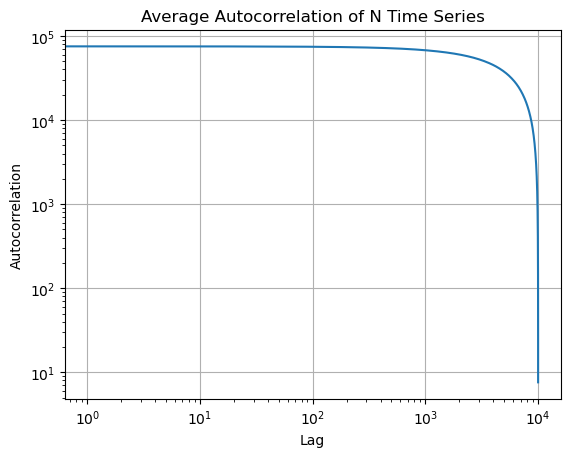

In [175]:
import numpy as np
from scipy.signal import correlate

# N個の独立した時系列データを持つ2次元配列 (N行×T列)
N, T = 100, 1000  # N個の時系列、各時系列の長さT
data = np.random.randn(N, T)  # 例としてランダムなデータを使用


# 全ての時系列に対して自己相関を計算 (axis=1で各行に対して自己相関を計算)
# 'same' モードで時系列の長さを維持
# !! numpy correlate does not support FFT
correlations = np.apply_along_axis(lambda x: correlate(x, x, mode='full'), axis=0, arr=hydrogen_bond_list)
print(np.shape(correlations))

# 自己相関の平均化 (axis=0で全ての時系列に対する平均を取る)
mean_correlation = np.mean(correlations, axis=1)[len(hydrogen_bond_list)-1:]

# 結果をプロット
import matplotlib.pyplot as plt
plt.plot(mean_correlation)
plt.title('Average Autocorrelation of N Time Series')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

In [176]:
#
# * 計算したhydrogen_bond_listの自己相関を求める
#
# https://stackoverflow.com/questions/643699/how-can-i-use-numpy-correlate-to-do-autocorrelation
#
import statsmodels.api as sm
import numpy as np

def autocorr(x):
    import numpy as np
    result = np.correlate(x, x, mode='full')
    return result[int(result.size/2):]

def autocorr_scipy(x):
    from scipy import signal
    result = signal.correlate(x, x, mode="same",method="fft")/len(x)
    return result[int(result.size/2):]

# * acfを計算する．
acf = 0 # np.zeros(len(traj_liquid))

for mol_id in range(NUM_MOL):
    acf += autocorr_scipy(hydrogen_bond_list[:,mol_id])

In [177]:
def calc_fourier(acf,TIMESTEP:float=2.5):
    # dt = 2* 10  # !! 0.5fs
    # au2ps = 2.4189e-17 /1.0e-15/1.0e3 
    # au2fs = 2.4189e-17 /1.0e-15
    # TIMESTEP = dt*au2fs
    TIMESTEP = TIMESTEP/1000 # fs to ps

    time_data=len(acf) # データの長さ
    freq=np.fft.fftfreq(time_data, d=TIMESTEP) # omega
    length=freq.shape[0]//2 + 1 # rfftでは，fftfreqのうちの半分しか使わない．
    rfreq=freq[0:length]

    #usage:: numpy.fft.fft(data, n=None, axis=-1, norm=None)
    ans=np.fft.rfft(acf, norm="forward" ) #こっちが1/Nがかかる規格化．
    #ans=np.fft.rfft(fft_data, norm="backward") #その他の規格化1:何もかからない
    #ans=np.fft.rfft(fft_data, norm="ortho")　　#その他の規格化2:1/sqrt(N))がかかる

    ans_real_denoise= ans.real-ans.real[-1] # 振幅が閾値未満はゼロにする（ノイズ除去）
    # print(ans.real)
    ans = ans_real_denoise + ans.imag*1j # 再度定義のし直しが必要

    # 2pi*f*L[ACF]
    ans_times_omega=ans*rfreq*2*np.pi

    # 誘電関数の計算
    # ffteps1の2項目の符号は反転させる必要があることに注意 !!
    # time_data*TIMESTEPは合計時間をかける意味
    ffteps1 = ans_times_omega.imag*(time_data*TIMESTEP)
    ffteps2 = ans_times_omega.real*(time_data*TIMESTEP)

    # 通常のfourier変換
    normal_fourier = ans.real*(time_data*TIMESTEP) # ここはrealが正しい？
    return rfreq, normal_fourier,ffteps2

In [178]:
vdos = calc_fourier(mean_correlation)
vdos2 = calc_fourier(acf)

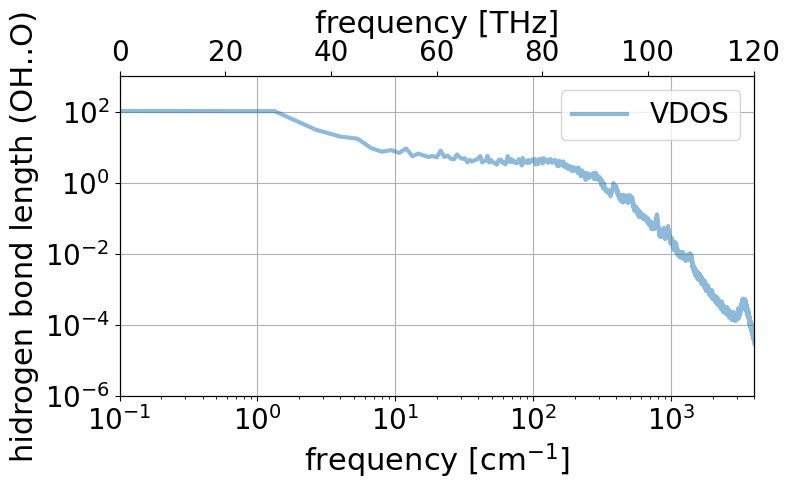

In [184]:

#
# * unit_cellの計算結果の図示
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,5),tight_layout=True) # figure, axesオブジェクトを作成

# ax.plot(diel_mean[0,:]*33.3, diel_mean[2,:]-0.0095*diel_mean[0,:],alpha=0.5, label="DNN", lw=3)  # 描画
# ax.plot(cpmd_diel_mean[0,:]*33.3, cpmd_diel_mean[2,:]-0.0095*cpmd_diel_mean[0,:], alpha=0.5, label="CPMD", lw=3)  # 描画

# ax.plot(diel_mean[0,:]*33.3, diel_mean[2,:],alpha=0.5, label="DNN", lw=3)  # 描画
# ax.plot(cpmd_diel_mean[0,:]*33.3, cpmd_diel_mean[2,:], alpha=0.5, label="CPMD", lw=3)  # 描画

ax.plot(vdos[0]*33.3, vdos[1], alpha=0.5, label="VDOS", lw=3)  # 描画
# ax.plot(vdos2[0]*33.3, vdos2[1], alpha=0.5, label="VDOS2", lw=3)  # 描画

# exp
# ax.scatter(expdata_eps1[:,0], expdata_eps1[:,1], label="Exp.", lw=3)  # 描画
# ax.scatter(expdata_eps2[:,0], expdata_eps2[:,1], label="Exp.", lw=3)  # 描画


# 各要素で設定したい文字列の取得
xticklabels = ax.get_xticklabels()
yticklabels = ax.get_yticklabels()
xlabel=r'frequency [$\mathrm{cm}^{-1}$]'
ylabel="hidrogen bond length (OH..O)"
# title="Dielectric function (liquid methanol)"


# 各要素の設定を行うsetコマンド
ax.set_xlabel(xlabel,fontsize=22)
ax.set_ylabel(ylabel,fontsize=22)

# ax.set_title(title,fontsize=22 )

XMAX=4000

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.1,XMAX)
ax.set_ylim(1e-6,1e3)
ax.grid()

# 2軸目（twinyを使い、y軸を共通にして同じグラフを書く）
ax2 = ax.twiny()
ax2.set_xlim(0,XMAX/33.3)
## ax2.plot(kayser/33.3, ffteps2_pred)
ax2.set_xlabel('frequency [THz]', fontsize=22)

ax.tick_params(axis='x', labelsize=20 )
ax.tick_params(axis='y', labelsize=20 )
ax2.tick_params(axis='x', labelsize=20 )

# ax.legend = ax.legend(*scatter.legend_elements(prop="colors"),loc="upper left", title="Ranking")

lgnd=ax.legend(loc="upper right",fontsize=20)
# lgnd.legendHandles[0]._sizes = [30]
# lgnd.legendHandles[0]._alpha = [1.0]


# pyplot.savefig("eps_real2.pdf",transparent=True)
# plt.show()
# fig.savefig("dielec_func_IR_0427_for_shorttalk2.pdf", transparent=True)
# ax.show()
# fig.delaxes(ax)

# plt.legend()
# plt.show()

# comp.plot(x="time",y=["mu_tot_x_pred","mu_tot_x_cpmd"])



# OH-OHの角度相関を調べる．

In [106]:
#
# * まずは，O原子に注目して，
import numpy as np
logger.setLevel(INFO)
ch.setLevel(INFO)
angle_y_coh=[]
counter = 0
NUM_ATOM_ALL = 17
NUM_ATOM     = 6
hydrogen_bond_list = np.zeros([len(traj_liquid),32,32])
# 最初に，H原子のリストを作成する
hydrogen_list = [NUM_ATOM_ALL*mol_id+5 for mol_id in range(32)]
# 
for counter,atoms in enumerate(traj_liquid): # frameに関するloop
    # print(hydrogen_list)
    for mol_id in range(32): # 分子数に関するloop
        # mol_idのO原子(1番目)と，他の分子のH原子の（最短）距離を計算する．
        # O: NUM_ATOM_ALL*mol_id+1が対応するindex
        distances = atoms.get_distances(NUM_ATOM_ALL*mol_id+1,hydrogen_list,mic=True)
        hb = hydrogen_bond_trii(distances)
        # print(hb)
        hydrogen_bond_list[counter,mol_id] = hb
        # 同一mol_idのものは0にする
        hydrogen_bond_list[counter,mol_id,mol_id] = 0    
                

KeyboardInterrupt: 

In [5]:
#
# * 2024/1/24：：現状こっちを有力視している
# * 次に，H原子に注目して，Hから2番目に近いO原子までの距離を単純に計算する．
# * Hを基準にすれば，H原子が水素結合できる分子は一つだけなのでわかりやすいかもしれない．
import numpy as np
logger.setLevel(INFO)
ch.setLevel(INFO)
angle_y_coh=[]
counter = 0
NUM_ATOM_ALL = 17
NUM_ATOM     = 6
hydrogen_bond_list = np.zeros([len(traj_liquid),32])
# 最初に，O原子のリストを作成する
oxygen_list = [NUM_ATOM_ALL*mol_id+1 for mol_id in range(32)]
# 
for counter,atoms in enumerate(traj_liquid): # frameに関するloop
    # print(hydrogen_list)
    for mol_id in range(32): # 分子数に関するloop
        # mol_idのO原子(1番目)と，他の分子のH原子の（最短）距離を計算する．
        # O: NUM_ATOM_ALL*mol_id+1が対応するindex
        distances = atoms.get_distances(NUM_ATOM_ALL*mol_id+5,oxygen_list,mic=True)
        hb = np.sort(distances)[1] # 2番目に小さい近い原子を選択
        # print(hb)
        hydrogen_bond_list[counter,mol_id] = hb
                

In [133]:
#
# * 計算したhydrogen_bond_listの自己相関を求める
#
# https://stackoverflow.com/questions/643699/how-can-i-use-numpy-correlate-to-do-autocorrelation
#
import statsmodels.api as sm
import numpy as np

def autocorr(x):
    import numpy as np
    result = np.correlate(x, x, mode='full')
    return result[int(result.size/2):]

def autocorr_scipy(x):
    from scipy import signal
    result = signal.correlate(x, x, mode="same",method="fft")/len(x)
    return result[int(result.size/2):]

# * acfを計算する．
acf = 0 # np.zeros(len(traj_liquid))

for mol_id in range(NUM_MOL):
    acf += autocorr_scipy(hydrogen_bond_list[:,mol_id])

In [116]:
#
# * 計算したhydrogen_bond_listの自己相関を求める
#
# https://stackoverflow.com/questions/643699/how-can-i-use-numpy-correlate-to-do-autocorrelation
#
import statsmodels.api as sm
import numpy as np

def autocorr(x):
    import numpy as np
    result = np.correlate(x, x, mode='full')
    return result[int(result.size/2):]

def autocorr_scipy(x):
    from scipy import signal
    result = signal.correlate(x, x, mode="same",method="fft")/len(x)
    return result[int(result.size/2):]

# * acfを計算する．
acf = 0 # np.zeros(len(traj_liquid))

for mol_id in range(32):
    for mol_id_2 in range(32):
        if mol_id_2 == mol_id:
            continue
        # acf += sm.tsa.stattools.acf(hydrogen_bond_list[:,mol_id,mol_id_2],fft=True,nlags=len(traj_liquid)) # 正規化される
        acf += autocorr_scipy(hydrogen_bond_list[:,mol_id,mol_id_2])

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [134]:
print(acf)

[102.41167358 102.40766217 102.40093359 ...  51.06324993  51.06073104
  51.05817829]


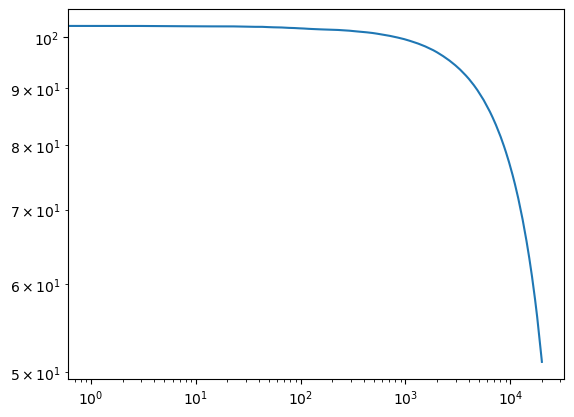

In [135]:
import matplotlib.pyplot as plt
plt.xscale("log")
plt.yscale("log")
plt.plot(acf)
# plt.xlim(0,600)

In [78]:
def calc_fourier(acf,TIMESTEP:float=2.5):
    # dt = 2* 10  # !! 0.5fs
    # au2ps = 2.4189e-17 /1.0e-15/1.0e3 
    # au2fs = 2.4189e-17 /1.0e-15
    # TIMESTEP = dt*au2fs
    TIMESTEP = TIMESTEP/1000 # fs to ps

    time_data=len(acf) # データの長さ
    freq=np.fft.fftfreq(time_data, d=TIMESTEP) # omega
    length=freq.shape[0]//2 + 1 # rfftでは，fftfreqのうちの半分しか使わない．
    rfreq=freq[0:length]

    #usage:: numpy.fft.fft(data, n=None, axis=-1, norm=None)
    ans=np.fft.rfft(acf, norm="forward" ) #こっちが1/Nがかかる規格化．
    #ans=np.fft.rfft(fft_data, norm="backward") #その他の規格化1:何もかからない
    #ans=np.fft.rfft(fft_data, norm="ortho")　　#その他の規格化2:1/sqrt(N))がかかる

    ans_real_denoise= ans.real-ans.real[-1] # 振幅が閾値未満はゼロにする（ノイズ除去）
    # print(ans.real)
    ans = ans_real_denoise + ans.imag*1j # 再度定義のし直しが必要

    # 2pi*f*L[ACF]
    ans_times_omega=ans*rfreq*2*np.pi

    # 誘電関数の計算
    # ffteps1の2項目の符号は反転させる必要があることに注意 !!
    # time_data*TIMESTEPは合計時間をかける意味
    ffteps1 = ans_times_omega.imag*(time_data*TIMESTEP)
    ffteps2 = ans_times_omega.real*(time_data*TIMESTEP)

    # 通常のfourier変換
    normal_fourier = ans.real*(time_data*TIMESTEP) # ここはrealが正しい？
    return rfreq, normal_fourier

In [93]:
vdos = calc_fourier(mean_correlation)

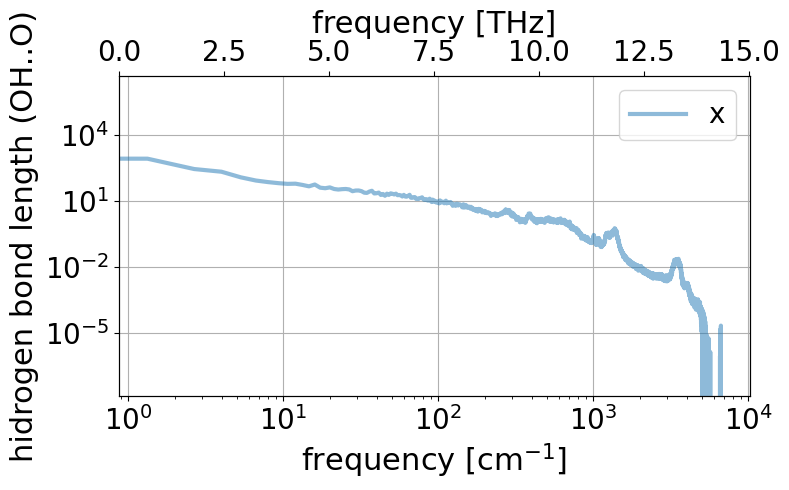

In [96]:

#
# * unit_cellの計算結果の図示
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,5),tight_layout=True) # figure, axesオブジェクトを作成

# ax.plot(diel_mean[0,:]*33.3, diel_mean[2,:]-0.0095*diel_mean[0,:],alpha=0.5, label="DNN", lw=3)  # 描画
# ax.plot(cpmd_diel_mean[0,:]*33.3, cpmd_diel_mean[2,:]-0.0095*cpmd_diel_mean[0,:], alpha=0.5, label="CPMD", lw=3)  # 描画

# ax.plot(diel_mean[0,:]*33.3, diel_mean[2,:],alpha=0.5, label="DNN", lw=3)  # 描画
# ax.plot(cpmd_diel_mean[0,:]*33.3, cpmd_diel_mean[2,:], alpha=0.5, label="CPMD", lw=3)  # 描画

ax.plot(vdos[0]*33.3, vdos[1], alpha=0.5, label="x", lw=3)  # 描画

# exp
# ax.scatter(expdata_eps1[:,0], expdata_eps1[:,1], label="Exp.", lw=3)  # 描画
# ax.scatter(expdata_eps2[:,0], expdata_eps2[:,1], label="Exp.", lw=3)  # 描画


# 各要素で設定したい文字列の取得
xticklabels = ax.get_xticklabels()
yticklabels = ax.get_yticklabels()
xlabel=r'frequency [$\mathrm{cm}^{-1}$]'
ylabel="hidrogen bond length (OH..O)"
# title="Dielectric function (liquid methanol)"


# 各要素の設定を行うsetコマンド
ax.set_xlabel(xlabel,fontsize=22)
ax.set_ylabel(ylabel,fontsize=22)

# ax.set_title(title,fontsize=22 )

XMAX=500

ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_xlim(0,XMAX)
# ax.set_ylim(0,0.02)
ax.grid()

# 2軸目（twinyを使い、y軸を共通にして同じグラフを書く）
ax2 = ax.twiny()
ax2.set_xlim(0,XMAX/33.3)
## ax2.plot(kayser/33.3, ffteps2_pred)
ax2.set_xlabel('frequency [THz]', fontsize=22)

ax.tick_params(axis='x', labelsize=20 )
ax.tick_params(axis='y', labelsize=20 )
ax2.tick_params(axis='x', labelsize=20 )

# ax.legend = ax.legend(*scatter.legend_elements(prop="colors"),loc="upper left", title="Ranking")

lgnd=ax.legend(loc="upper right",fontsize=20)
# lgnd.legendHandles[0]._sizes = [30]
# lgnd.legendHandles[0]._alpha = [1.0]


# pyplot.savefig("eps_real2.pdf",transparent=True)
# plt.show()
# fig.savefig("dielec_func_IR_0427_for_shorttalk2.pdf", transparent=True)
# ax.show()
# fig.delaxes(ax)

# plt.legend()
# plt.show()

# comp.plot(x="time",y=["mu_tot_x_pred","mu_tot_x_cpmd"])

